# Data Training, Regularizing, Feature Selection, and Testing

## Packages needed for analysis:

In [1]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# BL: These are just helpful as I debug things
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
# From: https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8
import timesplit as ts

# import our pipeline file [TO DO: NEEDS TO BE UPDATED TO USE OURS]
import pipeline as pline

## Import cleaned data on a Fips-date level

In [3]:
df = pd.read_csv("../Data/merged.csv", parse_dates=["date"], dtype={'fips': str})
df.head()

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,grocery_pharm,parks,transit,workplace,residential,new doses,cumulative doses,cases_next_week
0,IL,17001,Adams,2020-03-20,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.0,11.0,NaN,-7.0,-22.0,13.0,0.0,0.0,0.0
1,IL,17001,Adams,2020-03-21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-55.0,-14.0,NaN,-30.0,-15.0,NaN,0.0,0.0,0.0
2,IL,17001,Adams,2020-03-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-63.0,-42.0,NaN,NaN,-25.0,NaN,0.0,0.0,0.0
3,IL,17001,Adams,2020-03-23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-49.0,-20.0,NaN,-21.0,-29.0,14.0,0.0,0.0,0.0
4,IL,17001,Adams,2020-03-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66085,32276,48.8,33809,51.2,3679,5.6,3684,5.6,8060,12.2,7657,11.6,8105,12.3,4866,7.4,4251,6.4,41.5,15621,23.6,13186,20.0,61406,92.9,2731,4.1,297,0.4,527,0.8,14,0.0,113,0.2,1059,1.6,30192,3447,10417,13344,17583,19205,33041,43233,50182,8031,3605,4426,12597,19.1,4679,7.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-46.0,-20.0,NaN,NaN,-31.0,15.0,0.0,0.0,0.0


## Some gentle data processing to get rid of any remaining NAs

In [4]:
# filter down to dates with hospital
date_mask = (df["date"]>='7-31-2020')
df = df[date_mask]

# drop grocery_pharm, parks, transit because they have too much missingness
df.drop(columns=["grocery_pharm", "parks", "transit", "residential"], inplace = True)

# fill na's with mean for that state that date for retail_rec, workplace [TO DO: IS THIS REASONABLE?]
for var in ["retail_rec", "workplace"]:
    df[var] = df[["state", "date", var]].groupby(["state", "date"]).transform(lambda x: x.fillna(x.mean()))

# fill missing masks with 0 because the missings are from MO, who doesn't have a mask mandate
df["mask_mandate"] = df["mask_mandate"].fillna(0)

# drop na's (should just be the last week for each fips)
df = df.dropna()

df.describe()

,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,workplace,new doses,cumulative doses,cases_next_week
count,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,7.586800e+04,75868.000000,7.586800e+04,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000,7.586800e+04,75868.000000,75868.00000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000,7.586800e+04,75868.000000,75868.000000,7.586800e+04,7.586800e+04,7.586800e+04,7.586800e+04,7.586800e+04,7.586800e+04,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,75868.000000,7.586800e+04,75868.000000
mean,5157.038956,93.936726,33.259596,0.545718,33.252610,0.490431,33.163060,0.488717,1.010649e+05,4.957821e+04,49.883645,5.148671e+04,50.117008,6623.409329,6.494273,6742.902739,6.118514,13613.640652,11.630159,12496.415234,11.611020,13089.006722,12.860044,6999.399299,7.333487,6516.170586,6.954919,41.484360,19944.241657,22.809855,16172.431829,18.739208,7.811913e+04,91.350485,1.320622e+04,4.369502,278.88418,0.351894,3543.837600,0.984074,57.968102,0.057165,3122.824326,0.846729,9.541169e+03,3.597140,4.422942e+04,5910.361892,17230.689909,2.126703e+04,2.725623e+04,2.981611e+04,4.601552e+04,6.004560e+04,7.100016e+04,13118.642247,5795.158051,7323.484196,18811.547003,18.270105,2.294580e+04,8.649515,128.749657,1.615530,17.364422,0.172708,0.995940,1.297556,1.772618,2.913442,4.017741,4.449913,4.197409,0.431789,0.621079,-5.193752,-19.133926,164.652027,6.151541e+03,33.395213
std,21473.510024,455.881761,139.108506,3.389662,132.495562,2.312191,132.189254,2.311772,3.366181e+05,1.633324e+05,1.878297,1.732983e+05,1.878500,20755.725326,1.167539,22326.312195,2.293326,53619.880112,1.612048,44659.712118,1.151886,42947.858012,1.001042,21877.550783,0.806341,20210.735079,0.965660,3.978082,60427.031355,3.802161,48782.623904,3.305044,2.025780e+05,7.984876,7.807020e+04,6.396103,951.79296,0.395138,23437.279509,1.431893,212.414736,0.179511,29166.812353,1.400321,7.696449e+04,4.039276,1.434632e+05,21435.238431,61802.948526,7.543365e+04,9.517419e+04,1.034522e+05,1.534677e+05,1.942875e+05,2.274215e+05,47118.377691,20565.455191,26559.104938,62278.526676,1.836000,1.379778e+05,7.984876,577.398184,9.649264,64.672781,1.003362,4.566838,5.725642,7.072201,11.072198,14.216432,14.628187,13.881740,6.612432,0.485122,15.376650,13.507123,854.820695,3.284197e+04,132.947069

## Split test train

I realized that we should probably do all feature selection on only the training data since we shouldn't be touching the test data until the end

In [5]:
from sklearn.model_selection import train_test_split

# split df into features and labels
X = df.drop(columns=["cases_next_week"])
y = df["cases_next_week"]

# split df into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

# df that's just training
df_train = pd.concat([X_train, y_train], axis=1)

## Feature Selection

There are three main goals to feature selection:
Improve the accuracy with which the model is able to predict for new data.
Reduce computational cost.
Produce a more interpretable model.

I tried 2 methods from https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d

Feature Selection Sources:
    https://towardsdatascience.com/the-art-of-finding-the-best-features-for-machine-learning-a9074e2ca60d
    https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
Need to use a model to check which features? I would say Linear for simplicity but not sure that really works with this? So maybe logistic to start and check features and then we can compare other models? Not sure

BL: Not sure how we can use logistic since logistic is only used to predict a binary variable, right?

### Correlations

In [6]:
corr = df_train.corr()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(corr['cases_next_week'])
#print(corr['new_cases_7avg'])

cumulative_cases                        0.695749
cumulative_deaths                       0.707731
new_cases                               0.937362
new_deaths                              0.446090
new_cases_7avg                          0.970834
new_deaths_7avg                         0.653476
2weeksago_cases_7avg                    0.872294
2weeksago_deaths_7avg                   0.545951
total_pop                               0.792149
male                                    0.792153
perc_male                              -0.105611
female                                  0.792089
perc_female                             0.105534
age_15_19                               0.790855
p_age_15_19                             0.010195
age_20_24                               0.788588
p_age_20_24                             0.059062
age_25_34                               0.787710
p_age_25_34                             0.274653
age_35_44                               0.791201
p_age_35_44         

In [7]:
# lowest 20 (abs value)
corr['cases_next_week'].abs().sort_values()[:20]

p_age_15_19         0.010195
p_age_45_54         0.024059
p_hawaiian          0.031152
p_native            0.047683
p_under14           0.048403
p_age_20_24         0.059062
mask_mandate        0.091302
perc_female         0.105534
perc_male           0.105611
p_age_55_59         0.122189
p_age_60_64         0.128635
workplace           0.144537
age_median          0.164537
p_age_35_44         0.165079
cumulative doses    0.171821
retail_rec          0.183437
p_age_62over        0.197310
p_age_65over        0.201909
new doses           0.205602
p_age_25_34         0.274653
Name: cases_next_week, dtype: float64

In [8]:
# highest 20 (abs value)
corr['cases_next_week'].abs().sort_values()[-20:]

age_15_19                             0.790855
age_35_44                             0.791201
age_45_54                             0.791629
age_under14                           0.791968
female                                0.792089
total_pop                             0.792149
male                                  0.792153
prev_day_adult_admit_80+_7daysum      0.866537
2weeksago_cases_7avg                  0.872294
prev_day_adult_admit_70-79_7daysum    0.883391
prev_day_adult_admit_20-29_7daysum    0.895391
prev_day_adult_admit_50-59_7daysum    0.899750
prev_day_adult_admit_30-39_7daysum    0.902492
prev_day_adult_admit_60-69_7daysum    0.905927
prev_day_adult_admit_40-49_7daysum    0.912390
prev_day_adult_admit_7daysum          0.921897
total_adult_hospitalizations          0.924556
new_cases                             0.937362
new_cases_7avg                        0.970834
cases_next_week                       1.000000
Name: cases_next_week, dtype: float64

<AxesSubplot:>

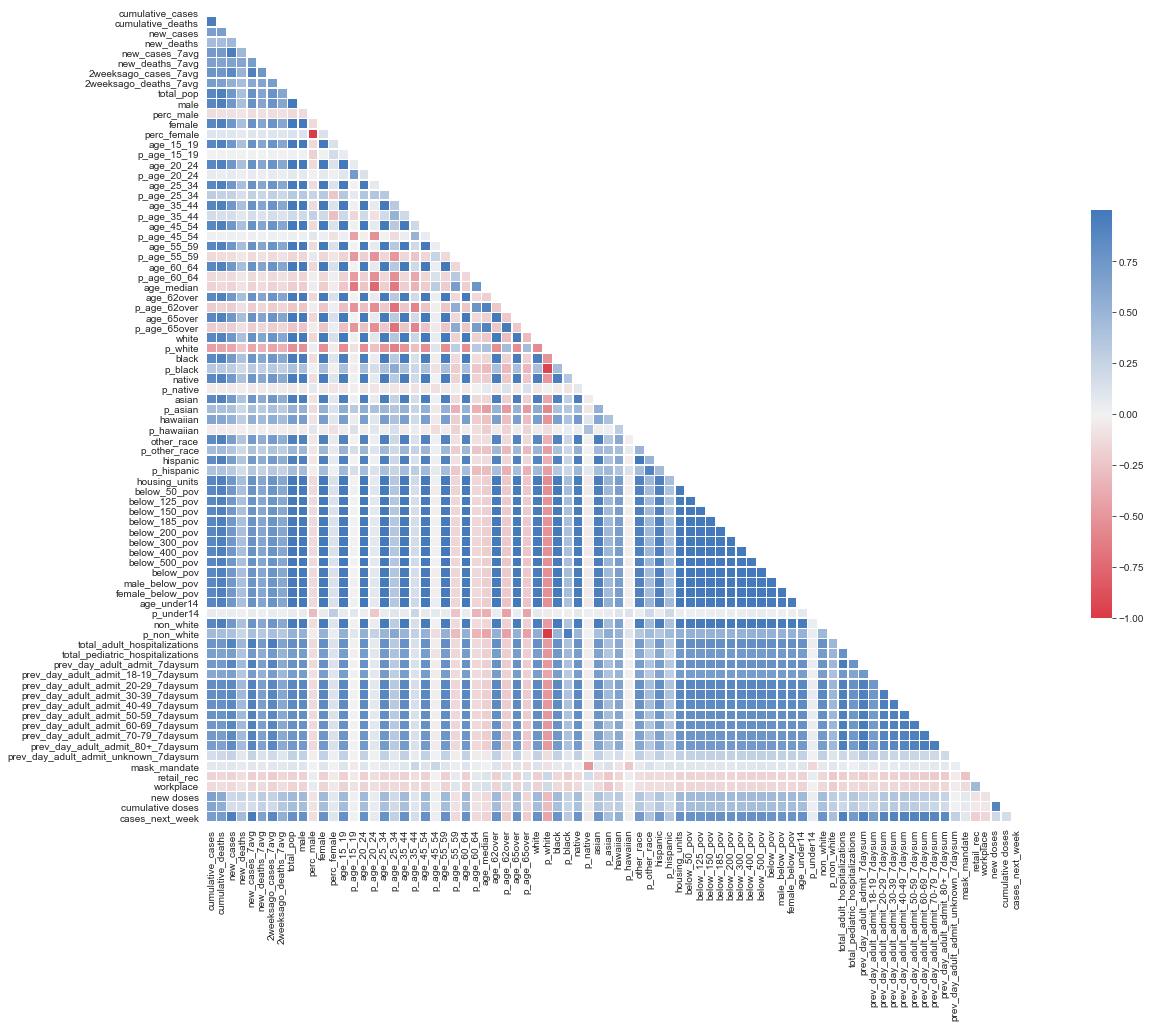

In [9]:
# Correlation plot


# use the pands .corr() function to compute pairwise correlations for the dataframe
#corr = normalized_df.corr()
corr = df_train.corr()
# visualise the data with seaborn
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(25, 15))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

### Variance threshold

"This is one of the most simple approaches to feature selection. The scikit-learn library has a method called VarianceThreshold . This method takes a threshold value and when fitted to a feature set will remove any features below this threshold. The default value for the threshold is 0 and this will remove any features with zero variance, or in other words where all values are the same."

In [10]:
from sklearn.feature_selection import VarianceThreshold
X = X_train.drop(columns=["state", "county", "fips"], axis=1)
selector = VarianceThreshold()
print("Original feature shape:", X.iloc[:, 1:].shape)
new_X = selector.fit_transform(X.iloc[:, 1:])
print("Transformed feature shape:", new_X.shape)

Original feature shape: (60694, 79)
Transformed feature shape: (60694, 79)


^ Looks like there's no variables with 0 variance (which is good).  Should we try setting different variances?

### sklearn's SelectKBest
https://machinelearningmastery.com/feature-selection-for-regression-data/


"Select features according to the k highest scores."

In [11]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# get feature selection model
fs = SelectKBest(score_func=mutual_info_regression, k='all')

# learn relationship from training data (drop non-numerical data)
fs.fit(X_train.drop(columns=["date", "state", "fips", "county"]), y_train.drop(columns=["date"]))

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x7fc4d0de28b0>)

In [12]:
feature_scores = pd.DataFrame({'variables': X_train.drop(columns=["date", "state", "fips", "county"]).columns.tolist(), 'score': fs.scores_})

# print out 30 most important features according to SelectKBest
feature_scores.sort_values(by="score", ascending=False).head(30)

,variables,score
4,new_cases_7avg,1.282546
6,2weeksago_cases_7avg,0.820059
2,new_cases,0.815619
11,female,0.725668
46,housing_units,0.725273
8,total_pop,0.722760
32,white,0.722128
28,age_62over,0.721400
9,male,0.721217
13,age_15_19,0.719953


## GridSearchCV for feature selection using time-based CV

In [13]:
# one hot encode categorical variables
X_train = pline.one_hot_encode(X_train, ["state", "fips"])
X_test = pline.one_hot_encode(X_test, ["state", "fips"])

# get list of numerical features for normalization
numerical_features = X_train.columns.tolist()[2:]
numerical_features.remove('mask_mandate')
numerical_features

# normalize
X_train, X_test = pline.normalize(X_train, X_test, numerical_features)

# drop county cause that's the same as fips
X_train = X_train.drop(columns=["county"])
X_test = X_test.drop(columns=["county"])

In [14]:
# set up time-based CV indices
tscv = ts.TimeBasedCV(train_period=21,
                      test_period=7,
                      freq='days')

tscv_indices = []

for train_index, test_index in tscv.split(X_train, date_column='date'):
    tscv_indices.append((train_index, test_index))

In [15]:
# https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration#custom-transformer-example-select-dataframe-columns
# Taken from above link, but this transformer just selects down to the provided variables in the parameter
# We can use this in our pipeline to select down to our n-most correlated variables

class SelectColumnsTransformer():
    def __init__(self, columns=None):
        self.columns = columns

    def transform(self, X, **transform_params):
        cpy_df = X[self.columns].copy()
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [16]:
# testing to make sure the transformer works
n_most_correlated = [(corr['cases_next_week'].abs().sort_values()[-21:-1]).index, # 20 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-31:-1]).index, # 30 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-51:-1]).index, # 50 most correlated variables
                    X_train.columns] # all variables

test = SelectColumnsTransformer(n_most_correlated[0])

test.transform(X_train) # works here but I can't get it to work in the pipeline??

,age_55_59,age_15_19,age_35_44,age_45_54,age_under14,female,total_pop,male,prev_day_adult_admit_80+_7daysum,2weeksago_cases_7avg,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_7daysum,total_adult_hospitalizations,new_cases,new_cases_7avg
0,0.338850,0.267989,0.248686,0.286355,0.272201,0.284230,0.275356,0.265922,0.268953,-0.092451,0.372739,0.427449,0.005520,0.28940,-0.072694,0.583900,0.129373,0.068141,-0.025883,-0.041777
1,0.254621,0.254763,0.185021,0.247980,0.224310,0.206382,0.208076,0.209858,-0.087254,-0.166253,-0.099799,-0.216201,0.005520,-0.22516,-0.072694,0.167557,-0.159869,-0.168357,-0.095897,-0.093650
2,-0.115781,-0.146456,-0.117018,-0.114186,-0.128222,-0.120480,-0.122536,-0.124708,-0.300978,-0.181013,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.151909,-0.152933
3,-0.201759,-0.217498,-0.193815,-0.203164,-0.185052,-0.198708,-0.199022,-0.199340,-0.300978,-0.085071,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.186916,-0.108471
4,-0.266936,-0.277960,-0.244261,-0.259859,-0.262499,-0.255010,-0.257155,-0.259411,-0.300978,-0.225295,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.172913,-0.204805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60689,-0.300601,-0.301719,-0.264562,-0.286598,-0.285603,-0.280136,-0.283172,-0.286372,-0.300978,-0.225295,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.235925,-0.227036
60690,-0.006449,-0.016227,0.026120,0.012301,0.011406,-0.006517,-0.004639,-0.002645,-0.087254,-0.195774,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,0.167557,-0.220763,-0.156448,-0.109900,-0.197395
60691,-0.291815,-0.291044,-0.257547,-0.278362,-0.276301,-0.270607,-0.272622,-0.274740,-0.300978,-0.240055,-0.302315,-0.216201,-0.261318,-0.22516,-0.280519,-0.248785,-0.266433,-0.221102,-0.228924,-0.249267
60692,-0.125598,-0.134458,-0.131663,-0.130407,-0.117992,-0.128578,-0.128370,-0.128139,-0.300978,-0.173633,-0.302315,-0.216201,-0.261318,-0.22516,-0.072694,-0.248785,-0.220763,-0.200685,-0.172913,-0.189984


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# list of the n most correlated variables, 
n_most_correlated = [(corr['cases_next_week'].abs().sort_values()[-21:-1]).index, # 20 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-31:-1]).index, # 30 most correlated variables
                   (corr['cases_next_week'].abs().sort_values()[-51:-1]).index, # 50 most correlated variables
                    X_train.columns] # all variables

scoring_metrics = ["neg_mean_squared_error", "r2"]

pipe = Pipeline([#('selector_ncorr', SelectColumnsTransformer()), # keeps just the n most correlated variables
                 ('feature_selection', SelectKBest()),
                 ('lr', LinearRegression())])
                  #'ridge', Ridge(alpha=0.1))

param_grid = {
    #'selector_ncorr': n_most_correlated,
    'feature_selection__k': [20, 30, 50, 'all'],
    'feature_selection__score_func': [mutual_info_regression]
}

fs_search = GridSearchCV(pipe, param_grid, cv=tscv_indices, scoring=scoring_metrics, refit = False)
fs_search.fit(X_train.drop(columns="date"), y_train.drop(columns="date"))

GridSearchCV(cv=[([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 132, 139,
                   140, 142, 149, 151, 164, 176, 181, 185, 208, 215, 228, 243,
                   245, 247, 258, 262, 264, ...],
                  [212, 219, 249, 281, 305, 307, 312, 330, 400, 435, 499, 558,
                   779, 797, 798, 872, 889, 1005, 1039, 1076, 1164, 1185, 1210,
                   1212, 1226, 1368, 1397, 1410, 1434, 1454, ...]),
                 ([21, 47, 51, 58, 73, 79, 87, 109, 117, 118, 121, 139, 142,
                   176, 212, 215, 219, 228, 243, 24...
                   603, 637, 651, 668, 698, 716, 758, 761, 861, 978, 1006, 1011,
                   1062, 1075, 1117, 1125, 1136, ...]), ...],
             estimator=Pipeline(steps=[('feature_selection', SelectKBest()),
                                       ('lr', LinearRegression())]),
             param_grid={'feature_selection__k': [20, 30, 50, 'all'],
                         'feature_selection__score_func': [<function mutual_

In [18]:
# get lists of hyperparameters
k = [dct['feature_selection__k'] for dct in fs_search.cv_results_["params"]]
fs_score_func = [dct['feature_selection__score_func'] for dct in fs_search.cv_results_["params"]]

# get list of scores
neg_mean_squared_error = fs_search.cv_results_["mean_test_neg_mean_squared_error"]
r2 = fs_search.cv_results_["mean_test_r2"]


# put into a dataframe
summary = pd.DataFrame({'k': k,
                        'fs_score_func': fs_score_func,
                        'neg_mean_squared_error': neg_mean_squared_error,
                        'r2': r2})

# print out
summary

,k,fs_score_func,neg_mean_squared_error,r2
0,20,<function mutual_info_regression at 0x7fc4d0de...,-2.427574e+03,8.986238e-01
1,30,<function mutual_info_regression at 0x7fc4d0de...,-1.514506e+03,9.201817e-01
2,50,<function mutual_info_regression at 0x7fc4d0de...,-1.588163e+03,9.344585e-01
3,all,<function mutual_info_regression at 0x7fc4d0de...,-1.936568e+21,-5.609748e+16


### Regression in the time loop

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [58]:
scores = []
df["hosp_next_week"]= df['total_adult_hospitalizations'].shift(-7)
df['more_hosp_next_week'] = np.where(df["hosp_next_week"] > df["total_adult_hospitalizations"], 1, 0)
X_new = df.drop(columns=["cases_next_week", "total_adult_hospitalizations", "hosp_next_week"])

y_new = df['more_hosp_next_week']

for train_index, test_index in tscv.split(X_train, date_column='date'):

    data_train   = X_new.iloc[train_index]
    target_train = y_new.iloc[train_index]

    data_test    = X_new.iloc[test_index]
    target_test  = y_new.iloc[test_index]
    
    data_train = pline.one_hot_encode(data_train, ["state", "fips"])
    data_test = pline.one_hot_encode(data_test, ["state", "fips"])

    # get list of numerical features for normalization
    numerical_features = data_train.columns.tolist()[2:]
    numerical_features.remove('mask_mandate')

    # normalize
    data_train, data_test = pline.normalize(data_train, data_test, numerical_features)

    # drop county cause that's the same as fips
    data_train = data_train.drop(columns=["county"])
    data_test = data_test.drop(columns=["county"])

    grid_params = {'lr__penalty':['l2', 'none'],
                   'lr__C':[0.01,0.1,1,10,100],
                   'lr__random_state':[0]
                   #'GaussianNB__priors':[None],
                   #'LinearSVC__C':[0.01,0.1,1,10,100],
                   #'LinearSVC__random_state':[0],
                   #'tree__max_depth':[1,3,5],
                   #'tree__min_samples_split':[2,5,10],
                   #'tree__criterion':["gini","entropy"],
                   #'tree__random_state':[0]
                  }
    # if needed, do preprocessing here
    pipe = Pipeline([
                 ('lr', LogisticRegression())
                  #('LinearSVC', LinearSVC()),
                  #('GaussianNB',GaussianNB()),
                  #('tree', DecisionTreeClassifier())
    ])
                  #'ridge', Ridge(alpha=0.1))

    clf = GridSearchCV(pipe, grid_params, scoring="accuracy",n_jobs=2,verbose=2,cv=10)
    clf.fit(data_train, target_train)

    preds = clf.predict(data_test)

    best=clf.best_estimator_
    results=pd.DataFrame(clf.cv_results_)
    output=results[["params","mean_test_accuracy"]]
    print("Best Model",best)
    output
    output.style.set_properties(subset=['params'],**{'width':'300px'})
    print("done")

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished


TypeError: invalid type promotion

In [26]:
# MODELS= {'LogisticRegression':LogisticRegression(solver='lbfgs',max_iter=1000),
#          'LinearSVC':LinearSVC(),
#          'GaussianNB':GaussianNB()}
# print(MODELS.values())
# GRID={'LogisticRegression':[{'penalty':x,'C':y,'random_state':0}
#                             for x in('l2','none') \
#                             for y in(0.01,0.1,1,10,100)],
#     'GaussianNB':[{'priors':None}],
#      'LinearSVC':[{'C':x,'random_state':0} \
#                   for x in(0.01,0.1,1,10,100)]}


SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x7fc4d0de28b0>)

## ~Resolved or scratch work~

### Missouri Spike -> Now resolved in data cleaning step

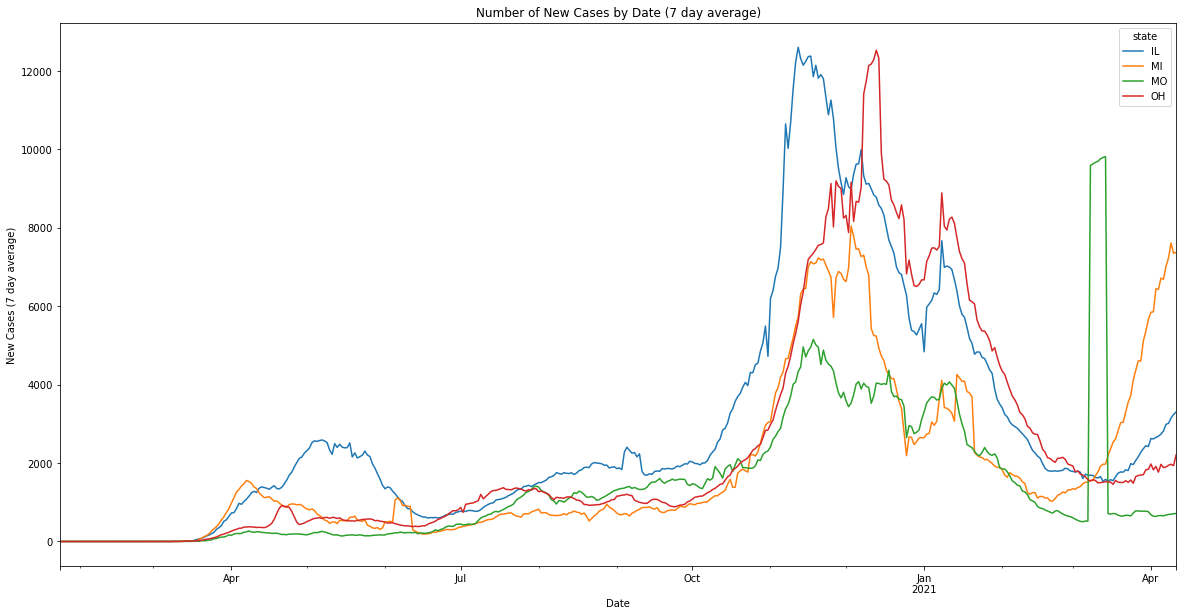

In [81]:
new_cases_state = df.groupby(["date","state"])["new_cases_7avg"].sum().unstack()
new_cases_state = new_cases_state.fillna(0)
new_cases_state
new_cases_state.plot(figsize=(20,10))
plt.title("Number of New Cases by Date (7 day average)")
plt.ylabel("New Cases (7 day average)")
plt.xlabel("Date")
plt.show()

Based on the above chart, clearly there is something wrong with March 8 for Missouri. According to research, they dumped probable cases into the system that day. Therefore, we will replace with the average of the previous 7 days.
This is also the case with Ohio December 8.

**Question: Do we need to adjust the 7 day average count with this information?**

BL: replotted above with the 7 day average variable that's already in the dataset, but seems like there's still a huge jump at those dates.  Maybe we can impute and add those cases proportionally to the prior dates? 

In [82]:
# from datetime import date
# df.dtypes
# # Since the data is on FIPS level, not sure best way to do this? 
# df["rolling_mean"] = df["new_cases"].rolling(7).mean().shift(1)

# #Missouri
# mask1 = (df['Date'] == date(2021, 3, 8)) & (df.state == "MO")
# #Ohio
# mask2 = (df['Date'] == date(2020, 12, 8)) & (df.state == "OH")

# df.loc[mask1, 'new_cases'] = df["rolling_mean"]
# df.loc[mask2, 'new_cases'] = df["rolling_mean"]
# df

In [83]:
df[(df['state']=='MO') & ((df['date']>= '2021-03-01') & (df['date']<= '2021-04-01'))]

,state,fips,county,date,cumulative_cases,cumulative_deaths,new_cases,new_deaths,new_cases_7avg,new_deaths_7avg,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,age_under14,p_under14,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,grocery_pharm,parks,transit,workplace,residential,new doses,cumulative doses
70157,MO,29001,Adair,2021-03-01,2308,20.0,6.0,0.0,2.0,0.0,5.0,0.0,25369,12321,48.6,13048,51.4,2881,11.4,5071,20.0,2753,10.9,2058,8.1,2407,9.5,1524,6.0,1138,4.5,27.6,4211,16.6,3656,14.4,23240,91.6,680,2.7,29,0.1,638,2.5,56,0.2,83,0.3,622,2.5,11542,2964,6884,7756,9599,10357,14175,17141,19091,5421,2526,2895,132013201241,5.25.24.9,2129,8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,NaN,NaN,NaN,-24.0,5.0,113.0,6620.0
70158,MO,29001,Adair,2021-03-02,2313,20.0,5.0,0.0,2.0,0.0,2.0,0.0,25369,12321,48.6,13048,51.4,2881,11.4,5071,20.0,2753,10.9,2058,8.1,2407,9.5,1524,6.0,1138,4.5,27.6,4211,16.6,3656,14.4,23240,91.6,680,2.7,29,0.1,638,2.5,56,0.2,83,0.3,622,2.5,11542,2964,6884,7756,9599,10357,14175,17141,19091,5421,2526,2895,132013201241,5.25.24.9,2129,8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-20.0,NaN,NaN,NaN,-21.0,5.0,76.0,6696.0
70159,MO,29001,Adair,2021-03-03,2315,20.0,2.0,0.0,2.0,0.0,5.0,0.0,25369,12321,48.6,13048,51.4,2881,11.4,5071,20.0,2753,10.9,2058,8.1,2407,9.5,1524,6.0,1138,4.5,27.6,4211,16.6,3656,14.4,23240,91.6,680,2.7,29,0.1,638,2.5,56,0.2,83,0.3,622,2.5,11542,2964,6884,7756,9599,10357,14175,17141,19091,5421,2526,2895,132013201241,5.25.24.9,2129,8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.0,NaN,NaN,NaN,-23.0,5.0,111.0,6807.0
70160,MO,29001,Adair,2021-03-04,2319,20.0,4.0,0.0,2.0,0.0,4.0,0.0,25369,12321,48.6,13048,51.4,2881,11.4,5071,20.0,2753,10.9,2058,8.1,2407,9.5,1524,6.0,1138,4.5,27.6,4211,16.6,3656,14.4,23240,91.6,680,2.7,29,0.1,638,2.5,56,0.2,83,0.3,622,2.5,11542,2964,6884,7756,9599,10357,14175,17141,19091,5421,2526,2895,132013201241,5.25.24.9,2129,8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-17.0,NaN,NaN,NaN,-21.0,6.0,147.0,6954.0
70161,MO,29001,Adair,2021-03-05,2321,20.0,2.0,0.0,3.0,0.0,4.0,0.0,25369,12321,48.6,13048,51.4,2881,11.4,5071,20.0,2753,10.9,2058,8.1,2407,9.5,1524,6.0,1138,4.5,27.6,4211,16.6,3656,14.4,23240,91.6,680,2.7,29,0.1,638,2.5,56,0.2,83,0.3,622,2.5,11542,2964,6884,7756,9599,10357,14175,17141,19091,5421,2526,2895,132013201241,5.25.24.9,2129,8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,NaN,NaN,NaN,-2.0,2.0,268.0,7222.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112461,MO,29510,St. Louis city,2021-03-28,22470,477.0,0.0,0.0,33.0,5.0,45.0,1.0,308174,149175,48.4,158999,51.6,15891,5.2,21841,7.1,61349,19.9,40386,13.1,36559,11.9,20224,6.6,20278,6.6,35.8,51849,16.8,40476,13.1,143401,46.5,143018,46.4,787,0.3,1036

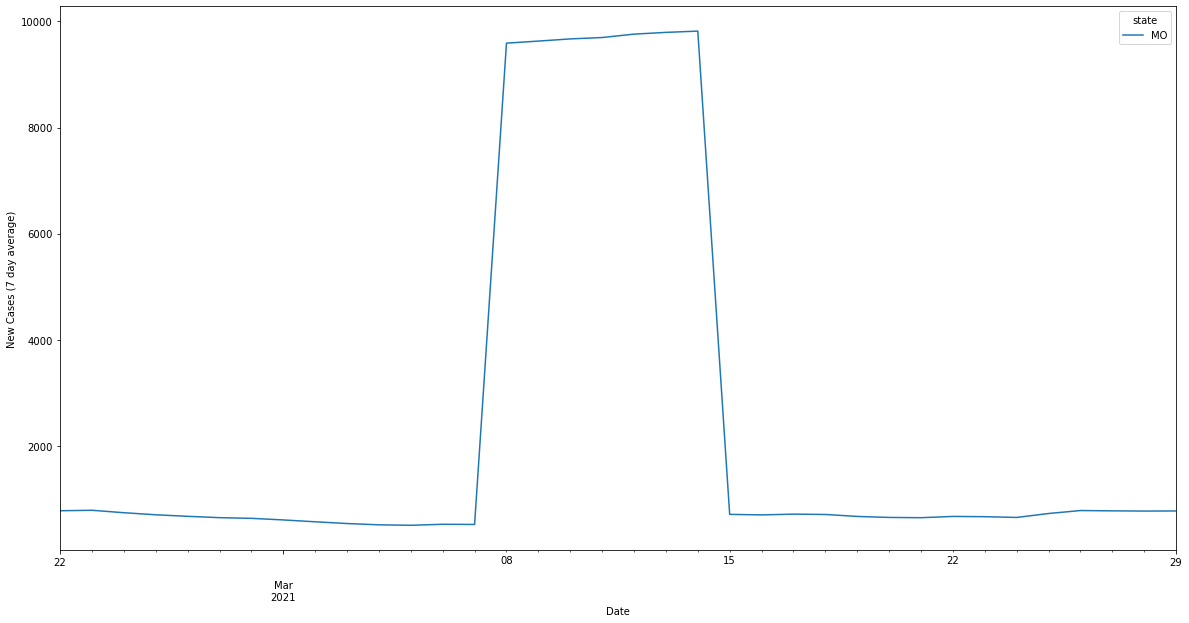

In [84]:
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().unstack().plot(figsize=(20,10))
plt.title("")
plt.ylabel("New Cases (7 day average)")
plt.xlabel("Date")
plt.show()

In [85]:
print("MO average of new_cases_7avg, over two weeks before 03/07/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-07'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

MO average of new_cases_7avg, over two weeks before 03/07/21


624.0

In [86]:
print("MO average of new_cases, over two weeks before 03/07/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-07'))].groupby(["date","state"])["new_cases"].sum().mean()

MO average of new_cases, over two weeks before 03/07/21


583.7142857142857

In [87]:
print("MO average of new_cases_7avg, 03/08/21 to 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-08') & (df['date']<= '2021-03-14'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

MO average of new_cases_7avg, 03/08/21 to 03/14/21


9708.857142857143

In [88]:
print("MO average of new_cases, 03/08/21 to 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-08') & (df['date']<= '2021-03-14'))].groupby(["date","state"])["new_cases"].sum().mean()

MO average of new_cases, 03/08/21 to 03/14/21


9816.57142857143

In [89]:
print("MO average of new_cases_7avg, over two weeks after 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-14') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

MO average of new_cases_7avg, over two weeks after 03/14/21


1277.4375

In [90]:
print("MO average of new_cases, over two weeks after 03/14/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-14') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases"].sum().mean()

MO average of new_cases, over two weeks after 03/14/21


678.5625

In [91]:
print("MO average of new_cases_7avg, 02/22/21 to 03/29/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

MO average of new_cases_7avg, 02/22/21 to 03/29/21


2425.527777777778

In [92]:
print("MO average of new_cases_7avg, 02/22/21 to 03/11/21")
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-11'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

MO average of new_cases_7avg, 02/22/21 to 03/11/21


2629.1666666666665

In [93]:
print("MO average of new_cases_7avg, 03/11/21 to 03/29/21")
df[(df['state']=='MO') & ((df['date']>= '2021-03-11') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum().mean()

MO average of new_cases_7avg, 03/11/21 to 03/29/21


2615.315789473684

I feel like we could potentially replace MO data from 03/08/21 - 03/14/21 with any of the values above. In the end, this is not that many days that we would be changing

I'm less concerned about the spike in OH from December. I feel like that one is less extreme.

In [94]:
df[(df['state']=='MO') & ((df['date']>= '2021-02-22') & (df['date']<= '2021-03-29'))].groupby(["date","state"])["new_cases_7avg"].sum()

date        state
2021-02-22  MO        778.0
2021-02-23  MO        787.0
2021-02-24  MO        741.0
2021-02-25  MO        702.0
2021-02-26  MO        673.0
2021-02-27  MO        648.0
2021-02-28  MO        635.0
2021-03-01  MO        605.0
2021-03-02  MO        570.0
2021-03-03  MO        537.0
2021-03-04  MO        513.0
2021-03-05  MO        504.0
2021-03-06  MO        523.0
2021-03-07  MO        520.0
2021-03-08  MO       9591.0
2021-03-09  MO       9630.0
2021-03-10  MO       9671.0
2021-03-11  MO       9697.0
2021-03-12  MO       9761.0
2021-03-13  MO       9794.0
2021-03-14  MO       9818.0
2021-03-15  MO        710.0
2021-03-16  MO        700.0
2021-03-17  MO        714.0
2021-03-18  MO        708.0
2021-03-19  MO        671.0
2021-03-20  MO        652.0
2021-03-21  MO        647.0
2021-03-22  MO        671.0
2021-03-23  MO        666.0
2021-03-24  MO        652.0
2021-03-25  MO        726.0
2021-03-26  MO        782.0
2021-03-27  MO        776.0
2021-03-28  MO        772.0
20

In [95]:
df['date'].min()

Timestamp('2020-01-24 00:00:00')

In [96]:
df['date'].max()

Timestamp('2021-04-11 00:00:00')

### Exploration of TimeSeriesSplit -> Determined not usable

In [97]:
#If using sklearn - How do we account for keeping Fips together? I dont think this can:
# Here are some alternatives: https://stackoverflow.com/questions/51963713/cross-validation-for-grouped-time-series-panel-data

tss = TimeSeriesSplit(n_splits = 3)
# Probably will want to take more variables out
X = df.drop(labels=['new_cases'], axis=1)
y = df['new_cases']
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


Thoughts on splitting with timeseriessplit:
    - if we go with this, I would do a much later n_splits (either # of months in our dataset, or # weeks/3)
    - what if we grouped by fips (and agg) before doing the timeseries split (I guess we would still have multiple rows per date)
    - what if we zoomed out to state level, and made 4 different models for each state. then we could group by date/state and run everything x4 to get us to 1 row per date
   

### Correlations run with normalized features -> Doesn't work as well as correlations on un-normalized features

In [122]:
normalized_df = X.merge(y, left_index=True, right_index=True)

In [124]:
normalized_df

,date,2weeksago_cases_7avg,2weeksago_deaths_7avg,total_pop,male,perc_male,female,perc_female,age_15_19,p_age_15_19,age_20_24,p_age_20_24,age_25_34,p_age_25_34,age_35_44,p_age_35_44,age_45_54,p_age_45_54,age_55_59,p_age_55_59,age_60_64,p_age_60_64,age_median,age_62over,p_age_62over,age_65over,p_age_65over,white,p_white,black,p_black,native,p_native,asian,p_asian,hawaiian,p_hawaiian,other_race,p_other_race,hispanic,p_hispanic,housing_units,below_50_pov,below_125_pov,below_150_pov,below_185_pov,below_200_pov,below_300_pov,below_400_pov,below_500_pov,below_pov,male_below_pov,female_below_pov,non_white,p_non_white,total_adult_hospitalizations,total_pediatric_hospitalizations,prev_day_adult_admit_7daysum,prev_day_adult_admit_18-19_7daysum,prev_day_adult_admit_20-29_7daysum,prev_day_adult_admit_30-39_7daysum,prev_day_adult_admit_40-49_7daysum,prev_day_adult_admit_50-59_7daysum,prev_day_adult_admit_60-69_7daysum,prev_day_adult_admit_70-79_7daysum,prev_day_adult_admit_80+_7daysum,prev_day_adult_admit_unknown_7daysum,mask_mandate,retail_rec,grocery_pharm,parks,transit,workplace,residential,new doses,cumulative doses,state_IL,state_MI,state_MO,state_OH,fips_17001,fips_17003,fips_17005,fips_17007,fips_17009,fips_17011,fips_17013,fips_17015,fips_17017,fips_17019,fips_17021,fips_17023,fips_17025,fips_17027,fips_17029,fips_17031,fips_17033,fips_17035,fips_17037,fips_17039,fips_17041,fips_17043,fips_17045,fips_17047,fips_17049,fips_17051,fips_17053,fips_17055,fips_17057,fips_17059,fips_17061,fips_17063,fips_17065,fips_17067,fips_17069,fips_17071,fips_17073,fips_17075,fips_17077,fips_17079,fips_17081,fips_17083,fips_17085,fips_17087,fips_17089,fips_17091,fips_17093,fips_17095,fips_17097,fips_17099,fips_17101,fips_17103,fips_17105,fips_17107,fips_17109,fips_17111,fips_17113,fips_17115,fips_17117,fips_17119,fips_17121,fips_17123,fips_17125,fips_17127,fips_17129,fips_17131,fips_17133,fips_17135,fips_17137,fips_17139,fips_17141,fips_17143,fips_17145,fips_17147,fips_17149,fips_17151,fips_17153,fips_17155,fips_17157,fips_17159,fips_17161,fips_17163,fips_17165,fips_17167,fips_17169,fips_17171,fips_17173,fips_17175,fips_17177,fips_17179,fips_17181,fips_17183,fips_17185,fips_17187,fips_17189,fips_17191,fips_17193,fips_17195,fips_17197,fips_17199,fips_17201,fips_17203,fips_26001,fips_26003,fips_26005,fips_26007,fips_26009,fips_26011,fips_26013,fips_26015,fips_26017,fips_26019,fips_26021,fips_26023,fips_26025,fips_26027,fips_26029,fips_26031,fips_26033,fips_26035,fips_26037,fips_26039,fips_26041,fips_26043,fips_26045,fips_26047,fips_26049,fips_26051,fips_26053,fips_26055,fips_26057,fips_26059,fips_26061,fips_26063,fips_26065,fips_26067,fips_26069,fips_26071,fips_26073,fips_26075,fips_26077,fips_26079,fips_26081,fips_26083,fips_26085,fips_26087,fips_26089,fips_26091,fips_26093,fips_26095,fips_26097,fips_26099,fips_26101,fips_26103,fips_26105,fips_26107,fips_26109,fips_26111,fips_26113,fips_26115,fips_26117,fips_26119,fips_26121,fips_26123,fips_26125,fips_26127,fips_26129,fips_26131,fips_26133,fips_26135,fips_26137,fips_26139,fips_26141,fips_26143,fips_26145,fips_26147,fips_26149,fips_26151,fips_26153,fips_26155,fips_26157,fips_26159,fips_26161,fips_26163,fips_26165,fips_29001,fips_29003,fips_29005,fips_29007,fips_29009,fips_29011,fips_29013,fips_29015,fips_29017,fips_29019,fips_29021,fips_29023,fips_29025,fips_29027,fips_29029,fips_29031,fips_29033,fips_29035,fips_29037,fips_29039,fips_29041,fips_29043,fips_29045,fips_29047,fips_29049,fips_29051,fips_29053,fips_29055,fips_29057,fips_29059,fips_29061,fips_29063,fips_29065,fips_29067,fips_29069,fips_29071,fips_29073,fips_29075,fips_29077,fips_29079,fips_29081,fips_29083,fips_29085,fips_29087,fips_29089,fips_29091,fips_29093,fips_29095,fips_29097,fips_29099,fips_29101,fips_29103,fips_29105,fips_29107,fips_29109,fips_29111,fips_29113,fips_29115,fips_29117,fips_29119,fips_29121,fips_29123,fips_29125,fips_29127,fips_29129,fips_29131,fips_29133,fips_29135,fips_29137,fips_29139,fips_29141,fips_29143,fips_29145,fi

I tried doing this with the normalized df and it didn't work so well

### original TimeBasedCV loop -> now wrapped into GridSearchCV

In [111]:
# one hot encode, 
df_encoded = one_hot_encode(df, ["state", "fips"])

# drop all rows with any na's just to get a model through
df_encoded = df_encoded.dropna()


tscv = ts.TimeBasedCV(train_period=21,
                      test_period=7,
                      freq='days')

# split df into features and labels
X = df_encoded.drop(columns=["cumulative_cases", "cumulative_deaths",
                     "new_cases", "new_deaths",
                     "new_cases_7avg", "new_deaths_7avg", "county",
                     "age_under14", "p_under14"])

y = df_encoded["new_cases_7avg"]

# get list of numerical features
numerical_features = X.columns.tolist()[4:]
numerical_features.remove('mask_mandate')
numerical_features

# create list for scores
r2s = []
mses = []

# grabbed most of this from the towards data science article
for train_index, test_index in tscv.split(X, date_column='date'):

    data_train   = X.loc[train_index].drop('date', axis=1)
    target_train = y.loc[train_index]

    data_test    = X.loc[test_index].drop('date', axis=1)
    target_test  = y.loc[test_index]

    # if needed, do preprocessing here
    
    # normalize numerical features
    data_train, data_test = normalize(data_train, data_test, numerical_features)

    clf = LinearRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # accuracy for the current fold only    
    r2score = clf.score(data_test,target_test)
    r2s.append(r2score)
    
    mse = mean_squared_error(target_test, preds, squared=True)
    mses.append(mse)

In [101]:
# average r2 on each fold (on our heavily subsetted data)
average_r2score = np.mean(r2s)
average_r2score

0.6950215774048538

In [102]:
# average mse on each fold (on our heavily subsetted data)
average_mse = np.mean(mses)
average_mse

11995.79587935378

### Identified Data Issues - now resolved in data cleaning
Data issues we're going to have to fix:
- variables like p_age...over have -1's
- under 14 variables (like "p_under14" and "age_under14") have weird values that seem either too high or have too many decimal points
- We're going to have to deal with the missingness in our dataset because linear regression can't have missing values
    - missingness in hospitals data
    - missingness in mobility data (some columns have NaN's sprinkled throughout so can we fill in those NaN's by interpolating?)
    - some missingness in mask data but I think we can update data to make it slightly better